In [7]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
    os.chdir(os.path.join(os.getcwd(), '../..'))
    print(os.getcwd())
    os.chdir("/Users/bpedigo/JHU_code/maggot_models")
except:
    pass


/Users/bpedigo/JHU_code/maggot_models


In [8]:
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspy.cluster import GaussianCluster, KMeansCluster
from graspy.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed, OmnibusEmbed
from graspy.models import DCSBMEstimator
from graspy.plot import gridplot, heatmap, pairplot
from graspy.utils import augment_diagonal, binarize, cartprod, pass_to_ranks, to_laplace
from joblib.parallel import Parallel, delayed
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import entropy
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ParameterGrid
from spherecluster import SphericalKMeans

from src.data import load_everything, load_networkx
from src.models import GridSearchUS
from src.utils import get_best, meta_to_array, relabel, savefig
from src.visualization import incidence_plot, screeplot

# Global general parameters
MB_VERSION = "mb_2019-09-23"
BRAIN_VERSION = "2019-09-18-v2"
GRAPH_TYPES = ["Gad", "Gaa", "Gdd", "Gda"]
GRAPH_TYPE_LABELS = [r"A $\to$ D", r"A $\to$ A", r"D $\to$ D", r"D $\to$ A"]
N_GRAPH_TYPES = len(GRAPH_TYPES)


# Functions


def annotate_arrow(ax, coords=(0.061, 0.93)):
    arrow_args = dict(
        arrowstyle="-|>",
        color="k",
        connectionstyle="arc3,rad=-0.4",  # "angle3,angleA=90,angleB=90"
    )
    t = ax.annotate("Target", xy=coords, xycoords="figure fraction")

    ax.annotate(
        "Source", xy=(0, 0.5), xycoords=t, xytext=(-1.4, -2.1), arrowprops=arrow_args
    )


def ase(adj, n_components):
    if PTR:
        adj = pass_to_ranks(adj)
    ase = AdjacencySpectralEmbed(n_components=n_components)
    latent = ase.fit_transform(adj)
    latent = np.concatenate(latent, axis=-1)
    return latent


def omni(adjs, n_components):
    if PTR:
        adjs = [pass_to_ranks(a) for a in adjs]
    omni = OmnibusEmbed(n_components=n_components // len(adjs))
    latent = omni.fit_transform(adjs)
    latent = np.concatenate(latent, axis=-1)  # first is for in/out
    latent = np.concatenate(latent, axis=-1)  # second is for concat. each graph
    return latent


def ase_concatenate(adjs, n_components):
    if PTR:
        adjs = [pass_to_ranks(a) for a in adjs]
    ase = AdjacencySpectralEmbed(n_components=n_components // len(adjs))
    graph_latents = []
    for a in adjs:
        latent = ase.fit_transform(a)
        latent = np.concatenate(latent, axis=-1)
        graph_latents.append(latent)
    latent = np.concatenate(graph_latents, axis=-1)
    return latent


def calc_weighted_entropy(true_labels, pred_labels):
    total_entropy = 0
    unique_true_labels = np.unique(true_labels)
    unique_pred_labels = np.unique(pred_labels)
    for true_label in unique_true_labels:
        probs = np.zeros(unique_pred_labels.shape)
        true_inds = np.where(true_labels == true_label)[0]
        class_pred_labels = pred_labels[
            true_inds
        ]  # get the predicted class assignments for this true class
        uni_inds, counts = np.unique(class_pred_labels, return_counts=True)
        probs[uni_inds] = counts
        probs /= len(class_pred_labels)
        e = entropy(probs)
        e *= len(class_pred_labels) / len(true_labels)
        e /= np.log(len(unique_pred_labels))
        total_entropy += e
    return total_entropy


def generate_experiment_arglist(latents, true_labels):
    arglist = []
    for i, (latent, latent_name) in enumerate(zip(latents, EMBED_FUNC_NAMES)):
        for j, (estimator, estimator_name) in enumerate(
            zip(ESTIMATORS, ESTIMATOR_NAMES)
        ):
            for k in range(min_clusters, max_clusters):
                arglist.append(
                    (
                        true_labels,
                        latent,
                        latent_name,
                        estimator,
                        estimator_name,
                        k,
                        params[j],
                    )
                )
    return arglist


def ari_scorer(estimator, latent, y=None):
    pred_labels = estimator.fit_predict(latent)
    return adjusted_rand_score(y, pred_labels)


def entropy_scorer(estimator, latent, y=None):
    pred_labels = estimator.fit_predict(latent)
    return calc_weighted_entropy(y, pred_labels)


def run_clustering(
    seed,
    true_labels,
    latent,
    latent_name,
    estimator,
    estimator_name,
    n_clusters,
    params,
):
    np.random.seed(seed)
    if estimator == GaussianCluster:
        e = estimator(min_components=n_clusters, max_components=n_clusters, **params)
    else:
        e = estimator(n_clusters=n_clusters, **params)
    e.fit(latent)
    ari = ari_scorer(e, latent, y=true_labels)
    ent = entropy_scorer(e, latent, y=true_labels)
    out_dict = {
        "ARI": ari,
        "Entropy": ent,
        "Embed": latent_name,
        "Cluster": estimator_name,
        "# Clusters": n_clusters,
    }
    return out_dict


def run_clustering_experiment(
    latents, true_labels, min_clusters, max_clusters, n_sims, seed=None
):
    if seed is not None:
        np.random.seed(seed)

    arglist = generate_experiment_arglist(latents, true_labels)
    arglist = arglist * n_sims

    seeds = np.random.randint(1e8, size=n_sims * len(arglist))

    outs = Parallel(n_jobs=-2, verbose=10)(
        delayed(run_clustering)(s, *i) for s, i in zip(seeds, arglist)
    )

    cluster_df = pd.DataFrame.from_dict(outs)

    return cluster_df


# Global alg parameters
PTR = True
EMBED_FUNC_NAMES = ["ASE", "OMNI", "ASE-Cat"]
EMBED_FUNCS = [ase, omni, ase_concatenate]

ESTIMATORS = [GaussianCluster, SphericalKMeans, KMeans]
ESTIMATOR_NAMES = ["GMM", "SKmeans", "Kmeans"]

# Set up plotting constants
plt.style.use("seaborn-white")
sns.set_palette("deep")
sns.set_context("talk", font_scale=1)

# Experiment 1: Compare clustering on right mushroom body
#   Preliminaries:
#       Load the right mushroom body data
#       Plot the summed graph
#       Plot the 4-color graphs, split up
#       Plot the ASE on summed latent positions
#       Plot the OMNI on 4-color latent positions
#       Plot the MASE on 4-color latent positions
#       Plot the split 4-color ASE concatenated positions
#       TODO: Compare to LSE
#   Experiment:
#       Cluster each of the above embeddings using skmeans, kmeans, gmm
#       Plot ARI vs. number of clusters
#       Plot Entropy metric vs. number of clusters

/miniconda3/envs/maggot_models/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


<Figure size 360x360 with 0 Axes>

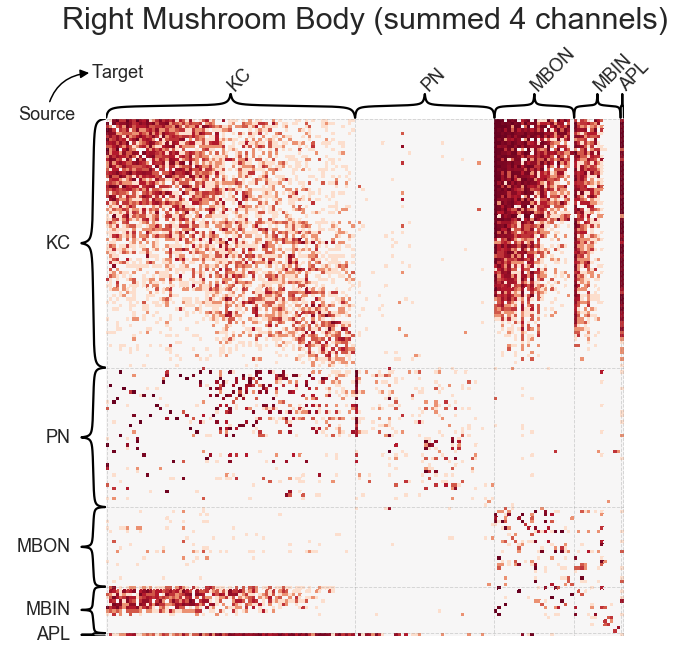

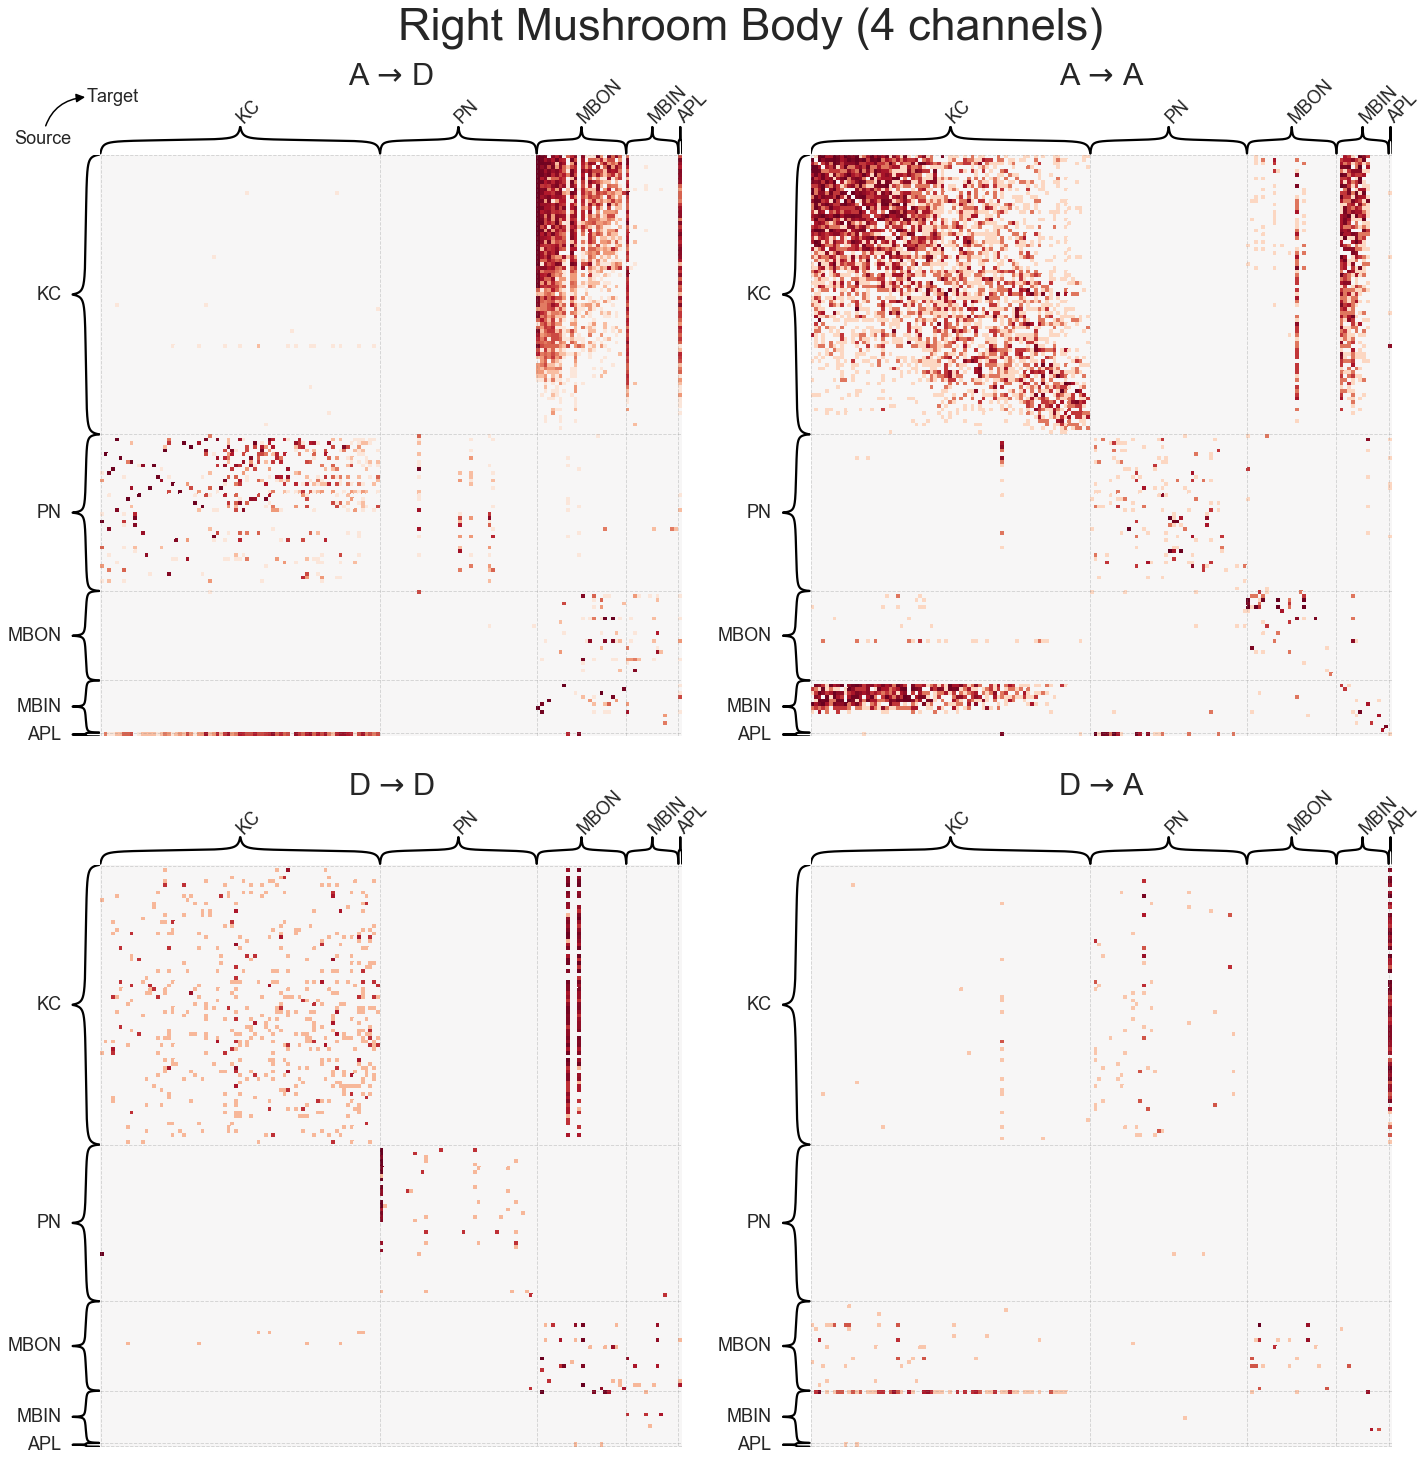

In [9]:
# Load graph and some metadata
adj, class_labels, side_labels = load_everything(
    "G", version=MB_VERSION, return_class=True, return_side=True
)

right_inds = np.where(side_labels == "right")[0]
adj = adj[np.ix_(right_inds, right_inds)]
degrees = adj.sum(axis=0) + adj.sum(axis=1)
sort_inds = np.argsort(degrees)[::-1]
class_labels = class_labels[right_inds]  # need to do right inds, then sort_inds
class_labels = class_labels[sort_inds]

# Remap the names
name_map = {
    "APL": "APL",
    "Gustatory PN": "PN",
    "KC 1 claw": "KC",
    "KC 2 claw": "KC",
    "KC 3 claw": "KC",
    "KC 4 claw": "KC",
    "KC 5 claw": "KC",
    "KC 6 claw": "KC",
    "KC young": "KC",
    "MBIN": "MBIN",
    "MBON": "MBON",
    "ORN mPN": "PN",
    "ORN uPN": "PN",
    "Unknown PN": "PN",
    "tPN": "PN",
    "vPN": "PN",
}
simple_class_labels = np.array(itemgetter(*class_labels)(name_map))

# Now load all 4 colors
color_adjs = []
for t in GRAPH_TYPES:
    # color_g = load_networkx(t, version="mb_2019-09-23")
    adj = load_everything(t)
    adj = adj[np.ix_(right_inds, right_inds)]
    adj = adj[np.ix_(sort_inds, sort_inds)]
    color_adjs.append(adj)

sum_adj = np.array(color_adjs).sum(axis=0)

# Plot the adjacency matrix for the summed graph
plt.figure(figsize=(5, 5))
ax = heatmap(
    sum_adj,
    inner_hier_labels=simple_class_labels,
    transform="simple-all",
    hier_label_fontsize=18,
    sort_nodes=False,
    cbar=False,
    title="Right Mushroom Body (summed 4 channels)",
    title_pad=90,
    font_scale=1.7,
)
annotate_arrow(ax, (0.135, 0.88))

# Plot the adjacency matrix for the 4-color graphs
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax = ax.ravel()
for i, g in enumerate(color_adjs):
    heatmap(
        g,
        inner_hier_labels=simple_class_labels,
        transform="simple-all",
        hier_label_fontsize=18,
        sort_nodes=False,
        ax=ax[i],
        cbar=False,
        title=GRAPH_TYPE_LABELS[i],
        title_pad=70,
        font_scale=1.7,
    )
plt.suptitle("Right Mushroom Body (4 channels)", fontsize=45, x=0.525, y=1.02)
plt.tight_layout()
annotate_arrow(ax[0])


/Users/bpedigo/JHU_code/graspy/graspy/embed/ase.py:138: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/Users/bpedigo/JHU_code/graspy/graspy/embed/ase.py:138: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/Users/bpedigo/JHU_code/graspy/graspy/embed/ase.py:138: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/Users/bpedigo/JHU_code/graspy/graspy/embed/ase.py:138: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)


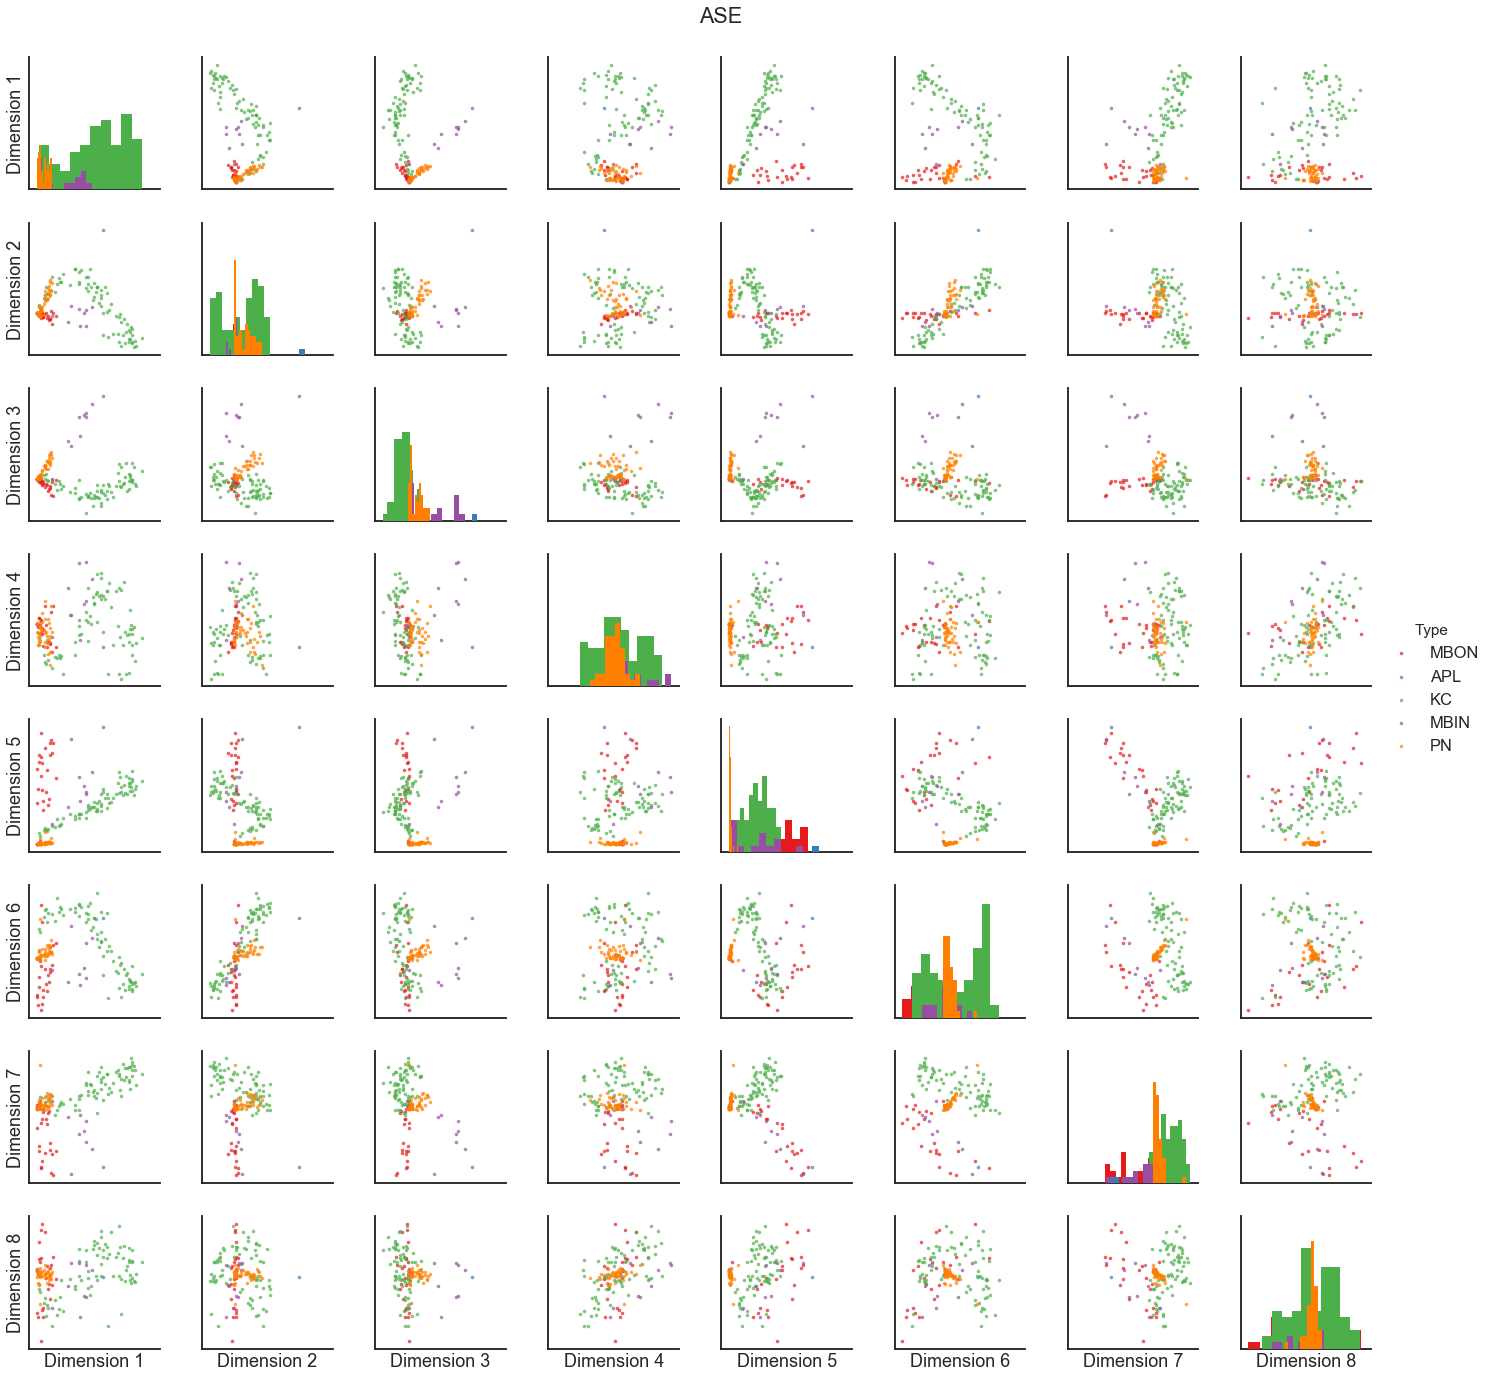

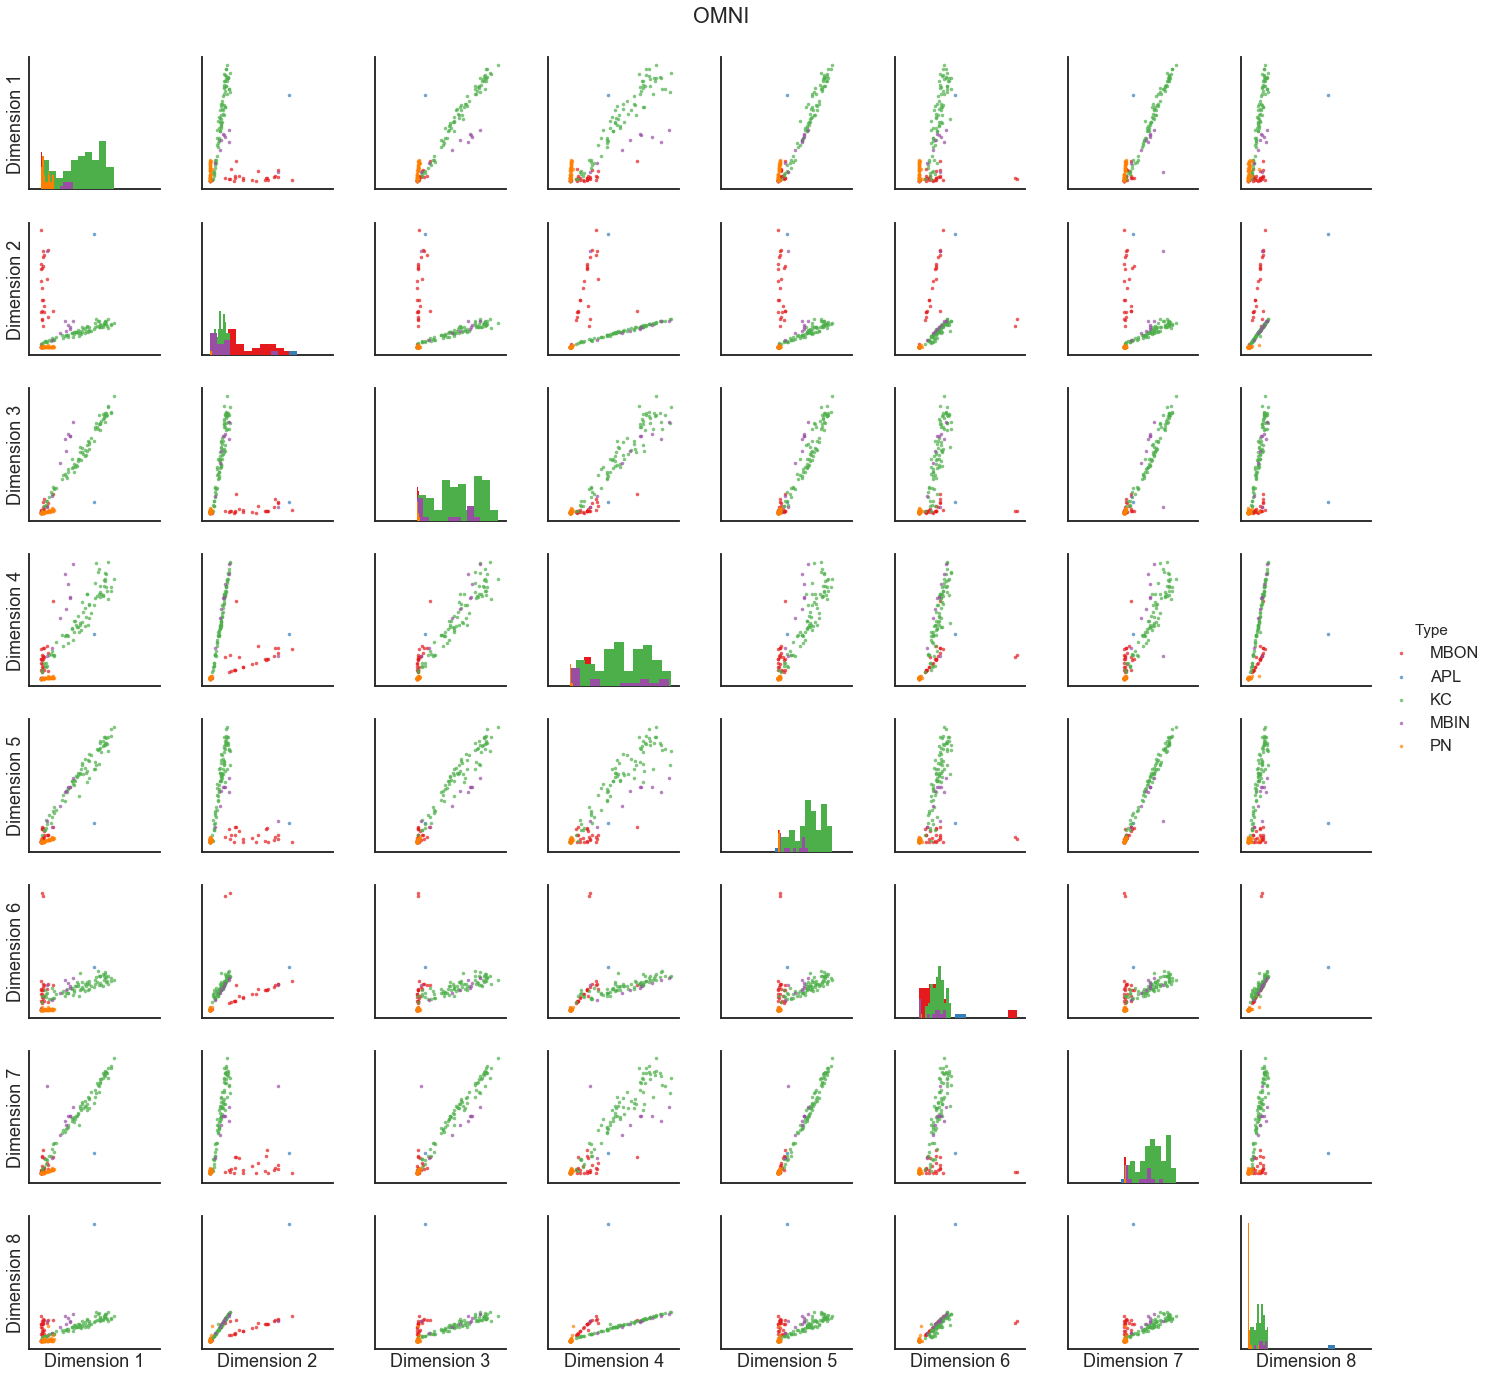

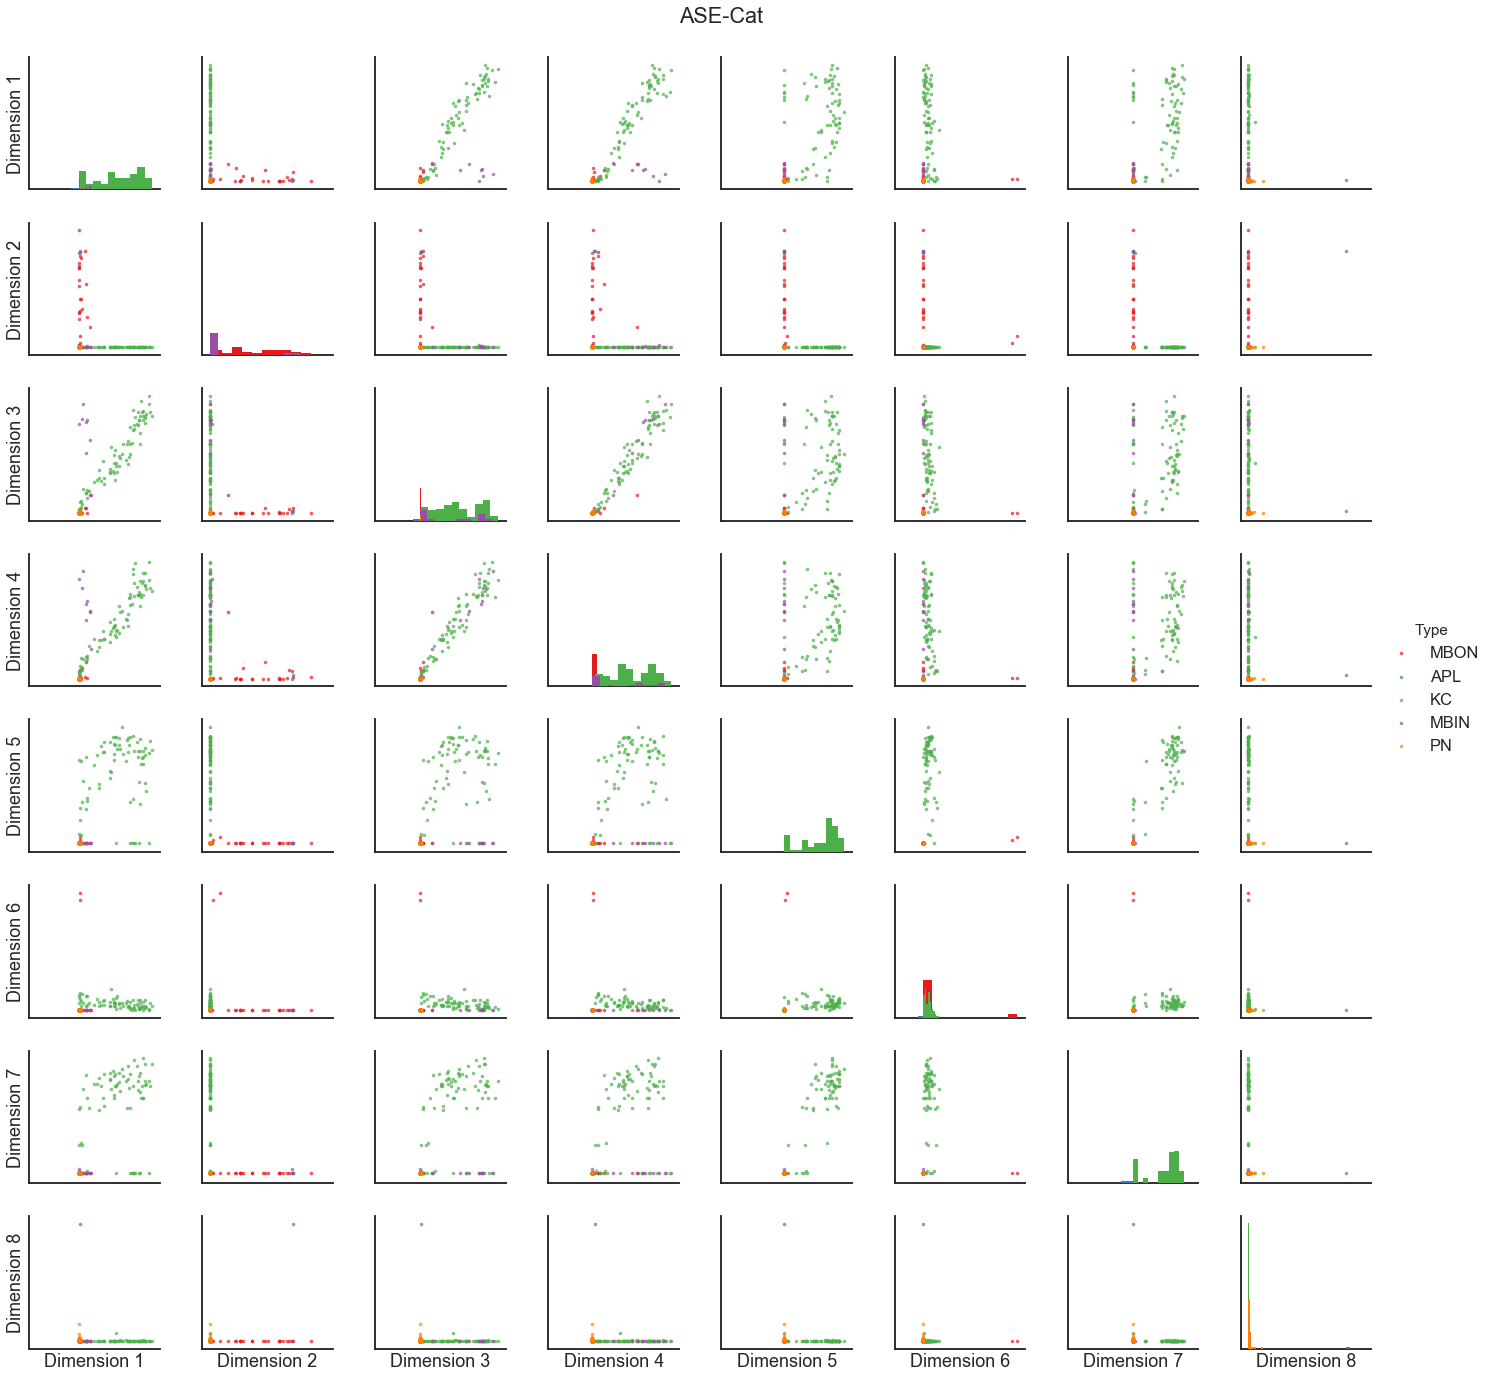

In [10]:
n_components = 4

ase_latent = ase(sum_adj, n_components)
omni_latent = omni(color_adjs, n_components)
ase_cat_latent = ase_concatenate(color_adjs, n_components)
latents = [ase_latent, omni_latent, ase_cat_latent]

for latent, name in zip(latents, EMBED_FUNC_NAMES):
    pairplot(latent, labels=simple_class_labels, title=name)



In [11]:

max_clusters = 12
min_clusters = 2
n_sims = 20

gmm_params = {"n_init": 10, "covariance_type": "all"}
skmeans_params = {"n_init": 10}
kmeans_params = {"n_init": 10}

true_labels = simple_class_labels

params = [gmm_params, skmeans_params, kmeans_params]

cluster_df = run_clustering_experiment(
    latents, true_labels, min_clusters, max_clusters, n_sims, seed=8888
)


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-2)]: Done  39 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-2)]: Done  50 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-2)]: Done  63 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-2)]: Done  76 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-2)]: Done  91 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-2)]: Done 106 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-2)]: Done 123 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-2)]: Done 140 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-2)]: Done 159 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-2)]: Done 178 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-2)]: Done 199 tasks      | elapsed:  

Text(0.5, 1.0, 'Mean entropy +/- 95% CI, n_sims = 20')

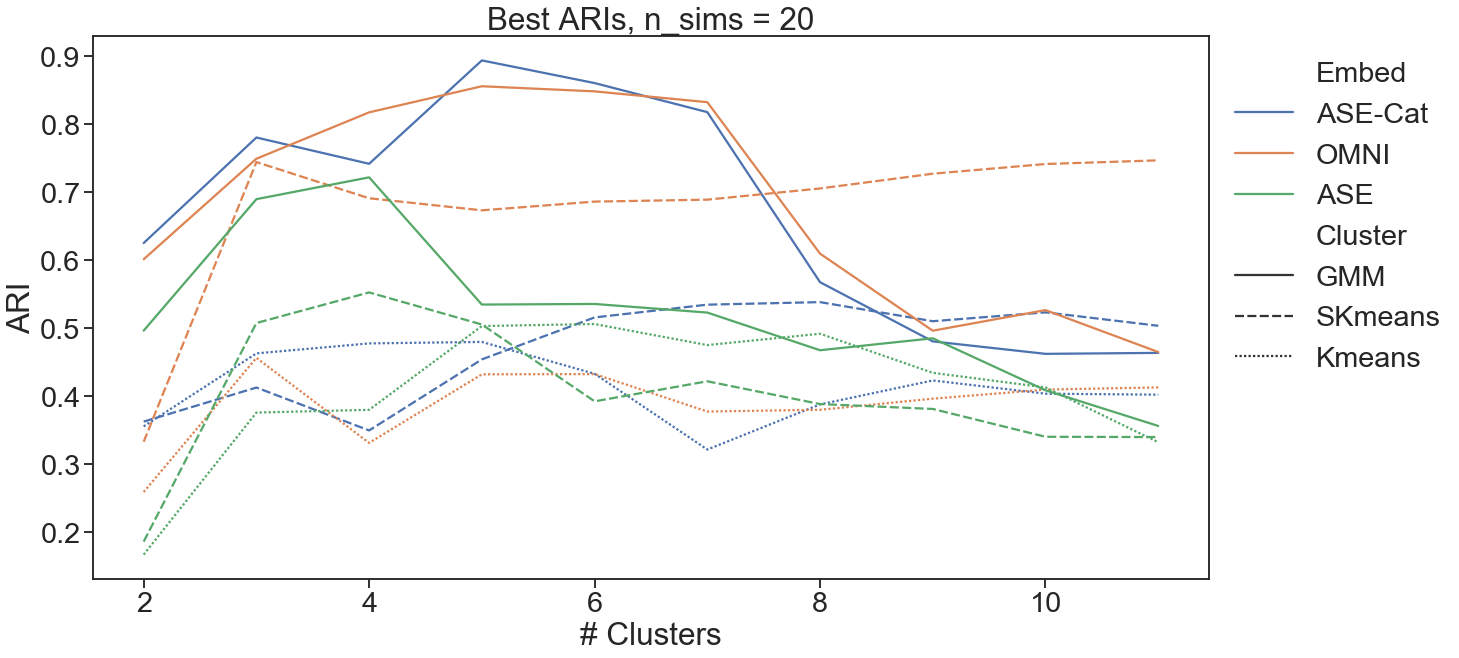

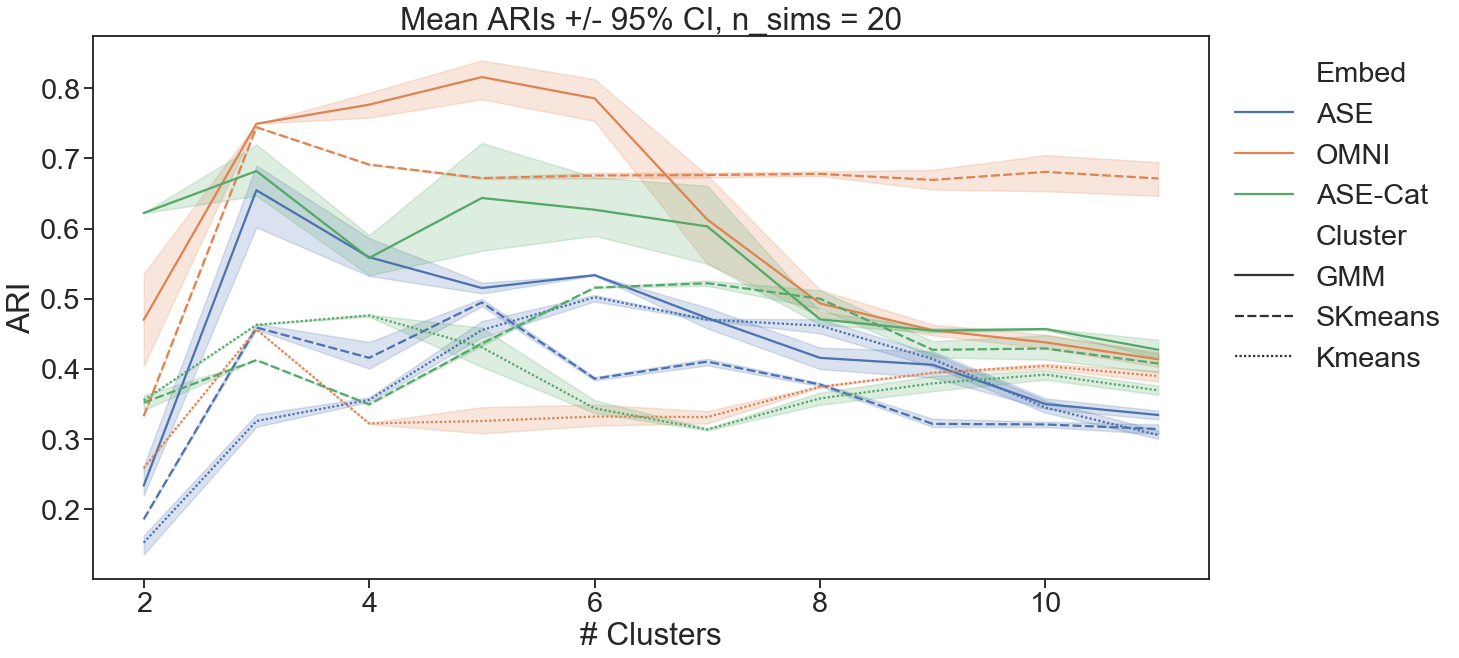

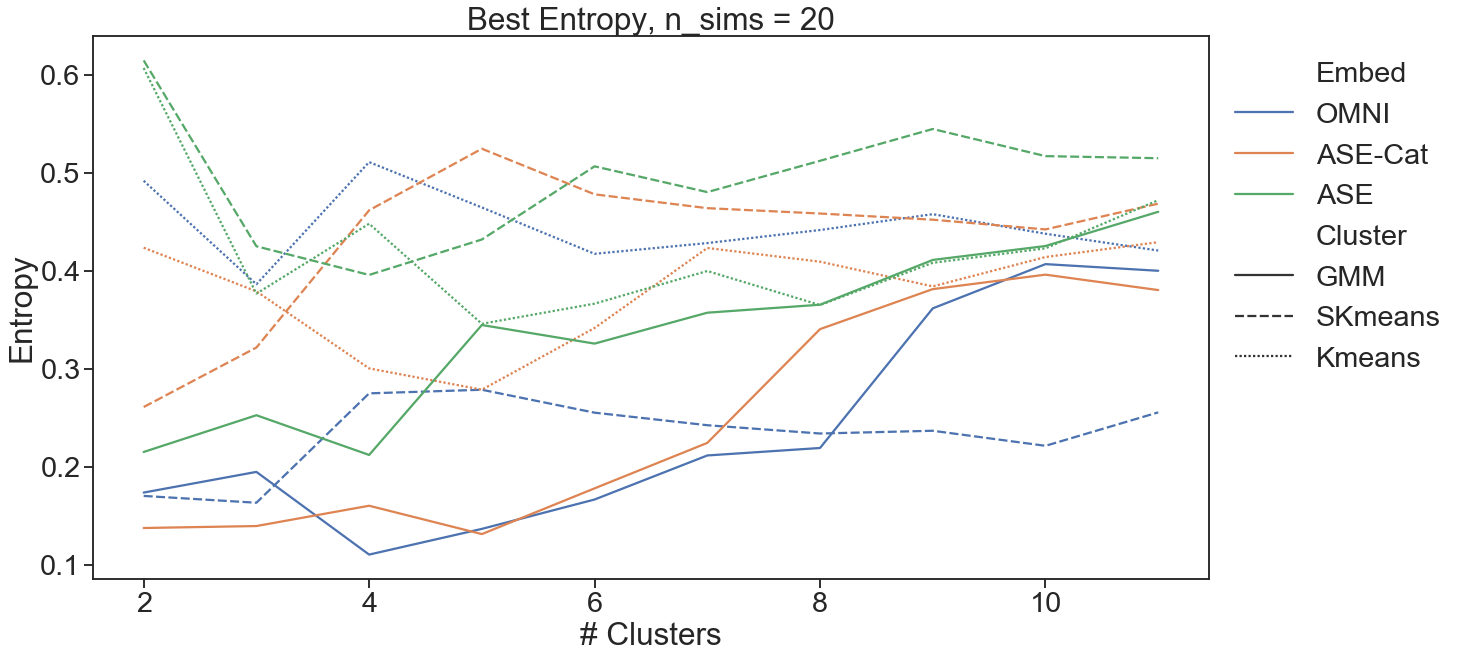

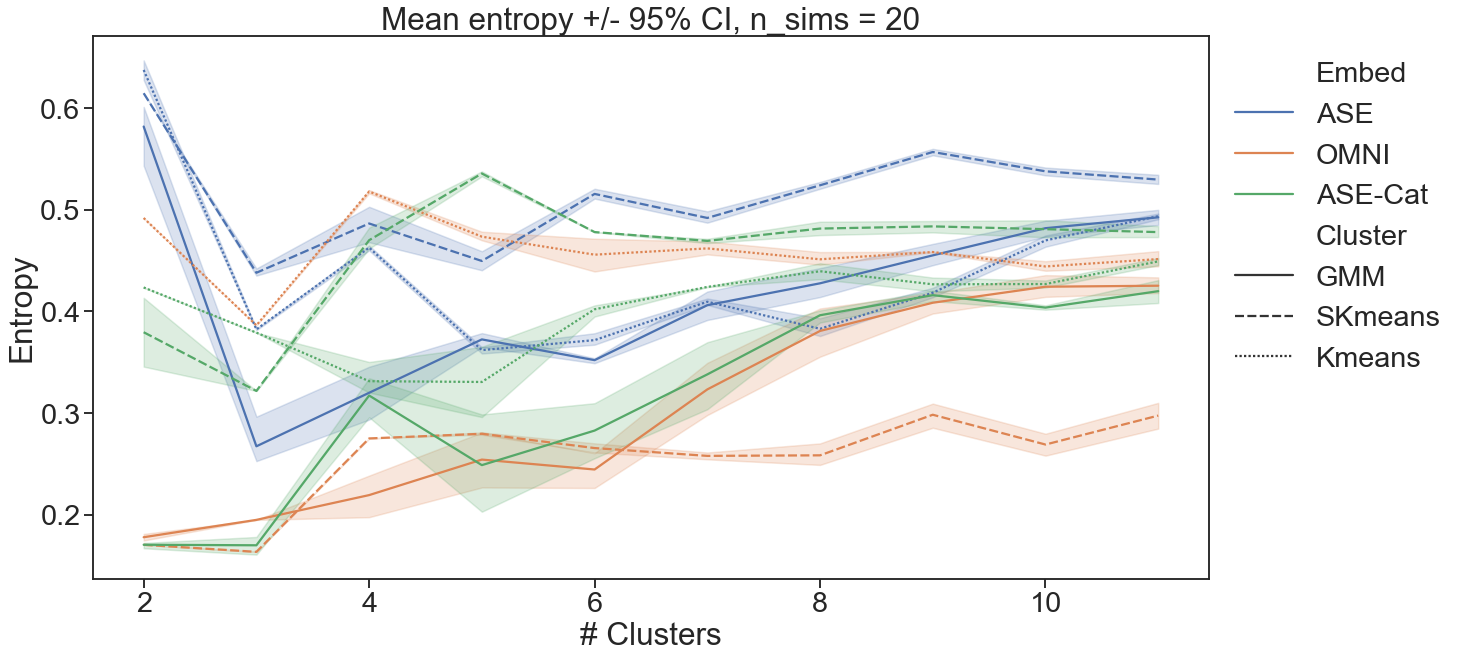

In [12]:
sns.set_context("talk", font_scale=1.75)
figsize = (20, 10)

# Get best ARI
plot_ari_df = cluster_df.sort_values("ARI", ascending=False).drop_duplicates(
    ["Embed", "Cluster", "# Clusters"]
)

plt.figure(figsize=figsize)
sns.lineplot(data=plot_ari_df, x="# Clusters", y="ARI", hue="Embed", style="Cluster")
plt.legend(bbox_to_anchor=(1, 1))
plt.title(f"Best ARIs, n_sims = {n_sims}")

plt.figure(figsize=figsize)
sns.lineplot(data=cluster_df, x="# Clusters", y="ARI", hue="Embed", style="Cluster")
plt.legend(bbox_to_anchor=(1, 1))
plt.title(f"Mean ARIs +/- 95% CI, n_sims = {n_sims}")

# Get best entropy
plot_ent_df = cluster_df.sort_values("Entropy", ascending=True).drop_duplicates(
    ["Embed", "Cluster", "# Clusters"]
)

plt.figure(figsize=figsize)
sns.lineplot(
    data=plot_ent_df, x="# Clusters", y="Entropy", hue="Embed", style="Cluster"
)
plt.legend(bbox_to_anchor=(1, 1))
plt.title(f"Best Entropy, n_sims = {n_sims}")

plt.figure(figsize=figsize)
sns.lineplot(data=cluster_df, x="# Clusters", y="Entropy", hue="Embed", style="Cluster")
plt.legend(bbox_to_anchor=(1, 1))
plt.title(f"Mean entropy +/- 95% CI, n_sims = {n_sims}")


# Experiment 2: Compare clustering on the full mushroom body
#   Preliminaries:
#       Load the full mushroom body
#       Generate same visualization plots as for the above
#   Experiment:
#       Same plots as for Experiment 1

# Experiment 3: Compare clustering on one hemisphere of the full data
#   Preliminaries:
#       Load the full graph
#       Generate the same visualization plots as for the above
#   Experiment:
#       Same plots as for Experiment 1

